# Introduction

The objective of the TensorSAT project is to build an SMT solver based on techniques analogous to [hyper-optimized tensor network contraction](https://arxiv.org/abs/2002.01935) techniques used in quantum simulation.

To achieve this, TensorSAT replaces predicates and formulae with categorical diagrams, taking their idealised semantics into the [hypergraph category](https://arxiv.org/abs/1806.08304) of sets and relations.
Functions and predicates are replaced by general relations, with synthetic composition rules used to contract diagrams and compute answers to satisfiability problems.

A **diagram** is formed by **wiring** together **boxes** from one or more **languages**, compatibly with the **types** specified by the boxes' **ports**.
Every language defines (parametrised families of) boxes and types, together with computational semantics in the form of contractions for arbitrary wirings of boxes in the language.
Such conctractions can be reduced to three special cases:

- `spider`: converts a wire &mdash; connecting any positive number of ports &mdash; into a box in the language.
- `transpose`: reorders the ports of any box in the language.
- `contract2`: contracts arbitrary wirings of any two boxes in the language (wired ports may be left open, but no copying is allowed).

Languages are allowed to overlap in boxes and types, and diagrams can involve boxes from multiple languages.

### A Categorical Aside

In categorical terms, each language is the hypergraph category freely generated by a parametrised family of types (object generators) and boxes (morphism generators).
Boxes are normalised to have the tensor unit as their domain: their signature takes the form $I \rightarrow X_0 \otimes ... \otimes X_{n-1}$, the indices $\lbrace 0, ..., n-1 \rbrace$ are the ports of the box, and we say that the generator $X_j$ is the type of port $j$.

A diagram involving boxes from one or more languages is a diagram in hypergraph category freely-generated by the union of their types and boxes.
The wiring of boxes in a diagram is a normalised representation of the diagram's compositional structure modulo the axioms of hypergraph categories (cf. [arXiv:1512.01602](https://arxiv.org/abs/1512.01602)).

Mathematically, languages have semantics in the hypergraph category Rel of sets and finitary relations.
Computationally, the semantics for each individual language are captured by providing an implementation for the `spider`, `transpose` and `contract2` rewrites which is sound for the Rel semantics (i.e. one such that the rewrite corresponds to an equation in Rel).

Formally, the rewrites equations turning a diagram in the language (two boxes, one box, and no boxes, respectively) into a single box in the same language.
Taken together, they give rise to a strongly confluent rewriting system which can be used to contract arbitrary diagrams in the language into a single box of the same language, providing computational semantics.

Types and boxes for multiple languages are allowed to overlap, and it is requried that the Rel semantics be compatible over such overlaps; that is, multiple languages assign the same set semantics to the same type, and the same relation semantics to the same box, whenever they have types and/or boxes in common.
Because of this, contraction in diagrams involving multiple languages does not necessarily result in a confluent rewriting system.

## Languages


Types and boxes are the basic building blocks of a diagrammatic language.
Diagrams are formed by wiring boxes (or sub-diagrams) together, relying on matching types to determine which wirings are allowed and which ones are not.

Every language defines boxes and/or types, by means of concrete subclasses of the abstract base classes `Box` and `Type`, respectively.

```py
from tensorsat.diagrams import Box, Type
```

As our running example, we will use the language `fin_rel` of "finite relations":

- The types of `fin_rel` are instances of the class `FinSet`. They are finite, explicitly enumerated sets in the form $\lbrace 0,...,n-1 \rbrace$.
- The boxes of `fin_rel` are instances of the class `FinRel`. They are finite relations bewtween finite sets, explicitly present by dense Boolean tensors.

Languages are implemented as sub-modules of the `tensorsat.lang` module.

In [1]:
from tensorsat.lang.fin_rel import FinSet, FinRel

## Types

Types are used to signal compatibility of wiring between ports of boxes.

The constructors of concrete sub-classes of `Type` define the parametrisation for the types in the language. In the case of `FinSet`, explicitly enumerated sets are parametrised by a strictly positive integer size.

In [2]:
bit = FinSet(2)  # {0, 1}
trit = FinSet(3) # {0, 1, 2}

Types can be combined into Shapes &mdash; sequences of types &mdash; by "tensor" product:

In [3]:
s = bit * bit * trit
print(f"{s = }")
print(f"{len(s) = }")
print(f"{list(s) = }")
print(f"{s[2] = }")

s = <Shape 0x28d8ed4d2d0: 3 components>
len(s) = 3
list(s) = [FinSet(2), FinSet(2), FinSet(3)]
s[2] = FinSet(3)


Iterated products of a type with itself can be constructed using the power operator:

In [4]:
kilobit = bit**1024
print(f"{kilobit = }")
print(f"{len(kilobit) = }")

kilobit = <Shape 0x28d9cfb99d0: 1024 components>
len(kilobit) = 1024


Types also define some utility methods to create special kinds of boxes. One such method defined on all types is `spider`, which creates the special box corresponding to the given number of copies of the type wired together. This implements the first of the three elementary rewrite rules for the language.

In [5]:
bit.spider(3)

<FinRel 0x28d9d1a8c50: 3 ports>

## Boxes

Boxes act as the atomic building blocks of diagrams.

The constructors of the concrete subclass(es) of `Box` define the parametrisatino of boxes in the language. In the case of `FinRel`, relations are parametrised by Boolean tensors, in the form of NumPy's `uint8` arrays with values in $\lbrace 0, 1 \rbrace$.

In [6]:
import numpy as np
and_ = FinRel(np.array([
    [
        [
            1 if out == inl & inr else 0
            for out in [0, 1]
        ]
        for inr in [0, 1]
    ]
    for inl in [0, 1]
], dtype=np.uint8))
and_

<FinRel 0x28d9d21a930: 3 ports>

Because the raw parametrisation can be inconvenient, concrete subclasses of `Box` typically offer additional utility constructors, in the form of class methods. In the case of `FinRel`, examples include constructors from:

- explicit sets of tuples, via `FinRel.from_set`
- input-output mappings of functions, via `FinSet.from_mapping`
- implementations of functions, via `FinSet.from_callable`


In [7]:
assert and_ == FinRel.from_set((2,2,2), {
    #       input bits at start ^^^ ^ output bit at end
    (a, b, a&b)
    for a in [0, 1]
    for b in [0, 1]
})
assert and_ == FinRel.from_callable(
    (2, 2), # input shape (2 bits input)
    2,      # output shape (1 bit output), same as (2,)
    lambda a, b: a&b # function implementation
    #            ^^^ same as (a&b,)
)
assert and_ == FinRel.from_mapping((2,2), 2, {
    (a, b): a&b
    #       ^^^ same as (a&b,)
    for a in [0, 1]
    for b in [0, 1]
})

All boxes have a `shape`, which defines the number and type of ports for the box.

In [8]:
print(f"{and_.shape = }")
print(f"{list(and_.shape) = }")

and_.shape = <Shape 0x28d8ed3bd10: 3 components>
list(and_.shape) = [FinSet(2), FinSet(2), FinSet(2)]


Each concrete `Box` subclass defines additional properties exposing the data parametrising them. In the case of `FinRel`, the `tensor` property exposes the underlying Boolean tensor (as a readonly view).

In [9]:
and_.tensor

array([[[1, 0],
        [1, 0]],

       [[1, 0],
        [0, 1]]], dtype=uint8)

Concrete `Box` subclasses also define properties and methods relevant to the language's semantics, especially relating boxes to various kinds of data which can be passed to utility constructors of the box class.

In [10]:
# Inverse of FinRel.from_set:
print(f"{set(and_.to_set()) = }")
# {(0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 1)}

# Inverse of FinRel.from_mapping:
input_ports = [0, 1]
print(f"{and_.to_mapping(input_ports) = }")
# {(0, 0): (0,), (0, 1): (0,), (1, 0): (0,), (1, 1): (1,)}

# Inverse of FinRel.from_callable:
and_func = and_.to_callable(input_ports)
print(f"{and_func = }")
# <function <lambda> at 0x000001C4F48B1D00>
input_sizes = tuple(t.size for t in and_.shape[input_ports])
for i0, i1 in np.ndindex(input_sizes):
    print(f"and_func({i0}, {i1}) = {and_func(i0, i1)}")

set(and_.to_set()) = {(1, 0, 0), (0, 0, 0), (1, 1, 1), (0, 1, 0)}
and_.to_mapping(input_ports) = {(0, 0): (0,), (0, 1): (0,), (1, 0): (0,), (1, 1): (1,)}
and_func = <function <lambda> at 0x0000028D9D2374C0>
and_func(0, 0) = (0,)
and_func(0, 1) = (0,)
and_func(1, 0) = (0,)
and_func(1, 1) = (1,)


## Libraries

Thematic collections of named types and boxes are made available as part of libraries, together with utility classes and functions. Libraries are implemented as sub-modules of the `tensorsat.lib` module.

For our subsequent examples, we will use types and boxes from the `bincirc` library, implementing binary circuits.

In [11]:
from tensorsat.lib.bincirc import (
    bit,   # bit type {0, 1}
    bit_0, # bit constant value 0
    bit_1, # bit constant value 1
    not_,  # unary NOT operator
    and_,  # binary AND operator
    or_,   # binary OR operator
    xor_,  # binary XOR operator
)

## Simple Contraction

Concrete `Box` subclasses also implement language-specific composition logic, which is accessible via two methods:

- the method `transpose`, for port permutation
- the class method `contract2`, for pairwise composition

We look at each one in turn, below.

The `transpose` method can be called on a box instance to produce another instance of the same box class &mdash; and, as a consequence, a box in the same language &mdash; where ports of the original box have been permuted as specified by the argument to the method. This implements the second of the three elementary rewrite rules for the language.

As an example of transposition, below we swap the right input of an AND gate with its output, obtaining a new relation:

In [12]:
and_transp = and_.transpose([0, 2, 1])
print(f"{sorted(and_.to_set())       = }")
print(f"{sorted(and_transp.to_set()) = }")

sorted(and_.to_set())       = [(0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 1)]
sorted(and_transp.to_set()) = [(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 1, 1)]


As another example, we verify that the XOR gate is invariant under such permutations:

In [13]:
xor_.transpose([0, 2, 1]) == xor_

True

The `contract2` class method can be called on a concrete `Box` subclass, to compose two boxes of that box class according to the given wiring, using Boolean tensor contraction. This implements the third and final of the three elementary rewrite rules for the language.

As a simple example of composition, we generate the relation corresponding to the CNOT binary function:

$$
(a, b) \mapsto (a, a \oplus b)
$$

In [14]:
cnot_ = FinRel.contract2(
    bit.spider(3),
    [0, 2, 4],
    xor_,
    [4, 1, 3],
    [0, 1, 2, 3]
)
assert cnot_ == FinRel.from_callable((2,2), (2,2), lambda a, b: (a, a^b))

As another simple example of composition, we generate the relation corresponding to the following binary function:

$$
(a, b, c) \mapsto a \wedge (b \vee c)
$$

In [15]:
func = FinRel.contract2(
    or_,
    [1, 2, 3],
    and_,
    [0, 3, 4]
)
assert func == FinRel.from_callable((2,2,2), 2, lambda a, b, c: a&(b|c))

Finally, we look at multiple pairwise ontractions. This is merely for educational purposes: in practice, such examples should be contracted using wirings and the `contract` class method. We generate the relation corresponding to the following binary function:

$$
(a, b, c) \mapsto (a \vee c) \wedge (b \vee c)
$$

The first contraction involves two `or_` gates, with input $c$ (at index 2) copied into both, resulting in the following intermediate function:

$$
(a, b, c) \mapsto (a \vee c, b \vee c)
$$

The second contraction connects the two outputs of the intermediate function above into the two inputs of an `and_` gate, reuslting in our desired function.


In [16]:
_func = FinRel.contract2(
    or_,
    [0, 2, 3],
    or_,
    [1, 2, 4],
    out_wires=[0, 1, 2, 3, 4]
    #   inputs ^^^^^^^  ^^^^ outputs
)
assert _func == FinRel.from_callable((2,2,2), (2,2), lambda a, b, c: ((a|c), (b|c)))
func = FinRel.contract2(
    _func,
    [0, 1, 2, 3, 4],
    and_,
    [3, 4, 5]
)
assert func == FinRel.from_callable((2,2,2), 2, lambda a, b, c: (a|c)&(b|c))

## Diagrams

Diagrams are the syntax used by TensorSAT to describe functions, predicates and formulae.

The internal data of diagrams consists of two parts:

- a `wiring`, describing the internal connectivity structure of the diagram;
- an assignment of boxes and/or sub-diagrams to (some of) the slots in the wiring.

As our first example, we look at the `full_adder` diagram from the `bincirc` library.

In [17]:
from tensorsat.lib.bincirc import half_adder, full_adder
full_adder

<Diagram 0x28d9d23adf0: 8 wires, 5 blocks, 5 ports>

We we can use the `draw_diagram` function from the `tensorsat.viz` module (which contains visualization utilities) to present draw the diagram:

- The diagram has 5 ports:
    - Ports 0, 1, and 2, on the left, are input ports;
    - Ports 3 and 4, on the right, are output ports.
- The diagram has 7 wires:
    - Wires 0, 1, and 2 are connected to the input ports;
    - Wires 3, 4, and 5 are internal;
    - Wires 6 and 7 are connected to the output ports;
- The diagram has 5 blocks, each filled with a box.

**Note:** In the nomenclature of hypergraph-categorical diagrams, **wire** is used to denote structural nodes which connect any number of ports: They can connect 2 ports (e.g. wires 2, 4, 6, and 7), as would be the case for ordinary wires, but can also connect multiple ports (e.g. wires 0, 1, 3, and 5) or a single port (in which case we say that the port is "discarded"). From the underlying perspective of symmetric monoidal categories, every object of a hypergraph category is equipped with a special commutative Frobenius algebra (SCFA), and wires are morphisms from the SCFA of the common type which they connect; from the perspective of hypergraph categories, on the other hand, wires are structural.

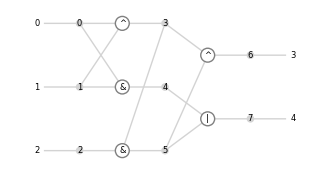

In [18]:
from tensorsat.viz import draw_diagram
from tensorsat.lib.bincirc import binop_labels # labels for binary operators

draw_diagram(
    full_adder,
    node_label={"box": binop_labels, "wire": str},
    layout="bfs",
    layout_kwargs={"sources": [0, 1, 2]},
    simplify_wires=False,
    figsize=(4, 2),
)

The connectivity structure for the boxes in the diagram is encoded into its `wiring`, a data structure encoding the following:

- `wire_types`: the assignment of a type to each wire (here stored as a `Shape`);
- `slot_wires_list`: for each slot (here, each box), a sequence assigning a wire to each port;
- `out_wires`: a sequence assigning a wire to each (outer) port for the diagram.

For example, the first entry of `slot_wires_list` is `(0, 1, 3)`, indicating that the `xor_` box at the top left (marked `^`) has its three ports connected to the wires 0, 1 and 3.
The (outer) ports of the diagram are connected to wires 0, 1, and 2 (on the left), and to wires 6 and 7 (on the right).

In [19]:
print(f"{full_adder.wiring = }")
print(f"{full_adder.wiring.wire_types = }")
print(f"{full_adder.wiring.slot_wires_list = }")
print(f"{full_adder.wiring.out_wires = }")

full_adder.wiring = <Wiring 0x28d9d21b950: 8 wires, 5 slots, 5 out ports>
full_adder.wiring.wire_types = <Shape 0x28d9d0f1990: 8 components>
full_adder.wiring.slot_wires_list = ((0, 1, 3), (0, 1, 4), (3, 2, 5), (3, 5, 6), (4, 5, 7))
full_adder.wiring.out_wires = (0, 1, 2, 6, 7)


The `"bfs"` layout use above is useful for small diagrams, but makes it harder to appreciate the structure of larger diagrams.
In general, we prefer the default [`"kamada_kawai"` layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.kamada_kawai_layout.html), which uses [force-directed graph drawing](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).
We also use the default `simplify_wires=True` value, which replaces wire nodes with simple edges wherever possible.

The result is an unordered, network-like presentation, which better reflects the unordered nature of tensor contractions in the hypergraph category of sets and relations.

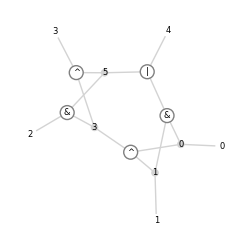

In [20]:
draw_diagram(
    full_adder,
    node_label={"box": binop_labels, "wire": str},
    figsize=(3, 3),
)

Diagrams are an immutable data structure, and can be instantiated by providing a wiring and an assignment of blocks (boxes, or other diagrams) for (some or all of) the slots of the wiring.

In [21]:
from tensorsat.diagrams import Diagram, Wiring

# Create wiring by specifying wire types and port-wire assignment (slots and outer):
wiring = Wiring(
    wire_types=bit**8,
    slot_wires_list=[(0, 1, 3), (0, 1, 4), (3, 2, 5), (3, 5, 6), (4, 5, 7)],
    out_wires=[0, 1, 2, 6, 7]
)
assert wiring == full_adder.wiring

# Create diagram by specifying wiring and slot-block assignment:
diagram = Diagram(wiring, {0: xor_, 1: and_, 2: and_, 3: xor_, 4: or_})
assert diagram == full_adder


For large diagrams, direct creation may become complicated. Instead, the `DiagramBuilder` class should be used to create diagrams incrementally, by:

1. Specifying "input" ports/wires.
2. Progressively connecting boxes onto existing wires.
3. Specifying "output" ports.

Below, we use this to recreate the `full_adder` diagram.

In [22]:
from tensorsat.diagrams import DiagramBuilder

diag = DiagramBuilder[FinSet]()
#                     ^^^^^^ diagram builder with wires typed by FinSet
a, b, c_in = diag.add_inputs(bit**3)
#                input types ^^^^^^
x1, = xor_ @ diag[a, b]
x2, = and_ @ diag[a, b]
x3, = and_ @ diag[x1, c_in]
s, = xor_ @ diag[x1, x3]
c_out, = or_ @ diag[x2, x3]
diag.add_outputs([s, c_out])
#   output wires ^^^^^^^^^^

my_full_adder = diag.diagram
#               ^^^^^^^^^^^^ assembles a diagram from current builder state
assert my_full_adder == full_adder

Anatony of a box application statement:

```py
    x1, = xor_ @ circ[a, b]
#                ^^^^^^^^^^ select wires 'a' and 'b' from diagram (here, wires 0 and 1)
#         ^^^^^^ apply 'xor_' box to diagram, with ports 0 and 1 connected to wires 'a' and 'b'
#   ^^ the application results in creation of a wire for port 2 (output) of 'xor_' box,
#      which we assign to variable 'x1'
```

Circuits can be added to circuit builders exactly as we did with gates, as shown in the example below of a 3-bit ripple-carry adder.

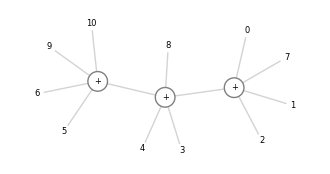

In [23]:
diag = DiagramBuilder[FinSet]()

c0, a0, b0, a1, b1, a2, b2 = diag.add_inputs(bit**7)
s1, c1 = full_adder @ diag[c0, a0, b0]
s2, c2 = full_adder @ diag[c1, a1, b1]
s3, c3 = full_adder @ diag[c2, a2, b2]
diag.add_outputs([s1, s2, s3, c3])

rc_adder_3 = diag.diagram

draw_diagram(
    rc_adder_3,
    node_label={"box": binop_labels, "subdiagram": {full_adder: "+"}},
    figsize=(4, 2),
)


The static method `Diagram.from_recipe` can be used to create diagrams by wrapping a diagram building "recipe" like the ones used above. The result is that the decorated `my_full_adder` is a diagram, equal to the original `full_adder`.

In [24]:
from collections.abc import Sequence
from tensorsat.diagrams.wirings import Wire

@Diagram.from_recipe
def my_full_adder(diag: DiagramBuilder[FinSet]) -> None:
    a, b, c_in = diag.add_inputs(bit**3)
    (x1,) = xor_ @ diag[a, b]
    (x2,) = and_ @ diag[a, b]
    (x3,) = and_ @ diag[x1, c_in]
    (s,) = xor_ @ diag[x1, x3]
    (c_out,) = or_ @ diag[x2, x3]
    diag.add_outputs([s, c_out])

assert my_full_adder == full_adder
print(f"{my_full_adder = }")

my_full_adder = <Diagram 0x28db3082940: 8 wires, 5 blocks, 5 ports>


The `Diagram.recipe` decorator can be used to wrap a parametric recipe into a diagram generating function.
For example, below we create a function which instantiates a ripple-carry adder circuit given the number `num_bits` of bits for the summands.

In [25]:
@Diagram.recipe
def rc_adder(diag: DiagramBuilder[FinSet], num_bits: int) -> None:
    inputs = diag.add_inputs(bit**(2*num_bits+1))
    outputs: list[Wire] = []
    c = inputs[0]
    for i in range(num_bits):
        a, b = inputs[2 * i + 1 : 2 * i + 3]
        s, c = full_adder @ diag[c, a, b]
        outputs.append(s)
    outputs.append(c)
    diag.add_outputs(outputs)

rc_adder

Diagram.recipe(__main__.rc_adder)

Recipes can be explicitly instantiated by calling them, passing the required parameter value(s).

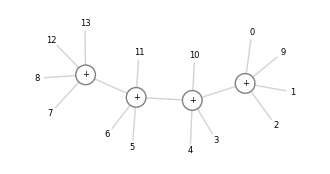

In [26]:
assert rc_adder(3) == rc_adder_3

draw_diagram(
    rc_adder(4),
    node_label={"box": binop_labels, "subdiagram": {full_adder: "+"}},
    figsize=(4, 2),
)

As an example of recipes being used in broader circuits, we implement the recipe for a multiply-add circuit.

In [27]:
from tensorsat.lib.bincirc import rc_adder, wallace_multiplier

@Diagram.recipe
def madd(diag: DiagramBuilder[FinSet], num_bits: int) -> Sequence[Wire]:
    """Computes ``x+y*z`` for ``n``-bit numbers ``x``, ``y`` and ``z``."""
    if num_bits <= 0:
        raise ValueError("Number of bits must be positive.")
    x = diag.add_inputs(bit**num_bits)
    y = diag.add_inputs(bit**num_bits)
    z = diag.add_inputs(bit**num_bits)
    m = wallace_multiplier(num_bits) @ diag[*y, *z]
    carry0, = bit_0 @ diag[()]
    add_inputs: list[Wire] = [carry0]
    for x_bit, m_bit in zip(x, m):
        add_inputs.append(x_bit)
        add_inputs.append(m_bit)
    return rc_adder(num_bits) @ diag[*add_inputs]

madd

Diagram.recipe(__main__.madd)

Note that multiple wires connection two blocks are grouped together, with a number on the edge indicating the number of wires.

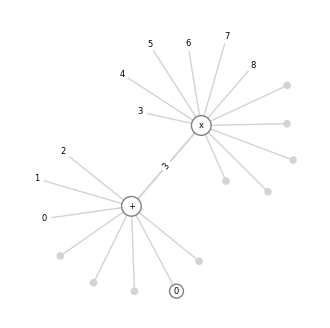

In [28]:
draw_diagram(
    madd(3),
    node_label={
        "box": binop_labels,
        "subdiagram": {
            wallace_multiplier: "x",
            rc_adder: "+",
        }
    },
    figsize=(4, 4),
)

Note that sub-diagrams are treated as if they were atomic boxes, even though they themselves have contents.
This can be seen above with the `rc_adder` sub-diagram (marked `+`) and the `wallace_multiplier` sub-diagram (marked `x`).
It exemplifies how the diagram data structure takes the form of a tree (or, more precisely, a directed acyclic graph): there is a top-level diagram, whose slots may be occupied by sub-diagrams, whose slots may in turn be occupied by sub-sub-diagrams, and so on.

The depth of such tree structures is captured by the `depth` property: in this example, the depth is 2, because both the `rc_adder` and `wallace_multiplier` recipes yield diagrams of depth 1 (they use `half_adder` and `full_adder` diagrams internally, which don't have sub-diagrams and hence have depth 0).

In [29]:
madd_3 = madd(3)
print(f"{madd_3 = }")
print(f"{madd_3.blocks[0] = }") # wallace_multiplier
print(f"{madd_3.blocks[1] = }") # bit_0
print(f"{madd_3.blocks[2] = }") # rc_adder


madd_3 = <Diagram 0x28db309dc20: 22 wires, 3 blocks, depth 2, 9 ports>
madd_3.blocks[0] = <Diagram 0x28db3139c70: 39 wires, 21 blocks, depth 1, 14 ports>
madd_3.blocks[1] = <FinRel 0x28d9d21b470: 1 ports>
madd_3.blocks[2] = <Diagram 0x28db3139d60: 13 wires, 3 blocks, depth 1, 11 ports>


Below we show the nested (left) and flat (right) version of three diagrams:

- a 3-bit `rc_adder`
- a 3-bit `wallace_multiplier`
- a 3-bit `madd` 

We use `draw_diagram.s` to quickly draw multiple diagrams in a given grid.

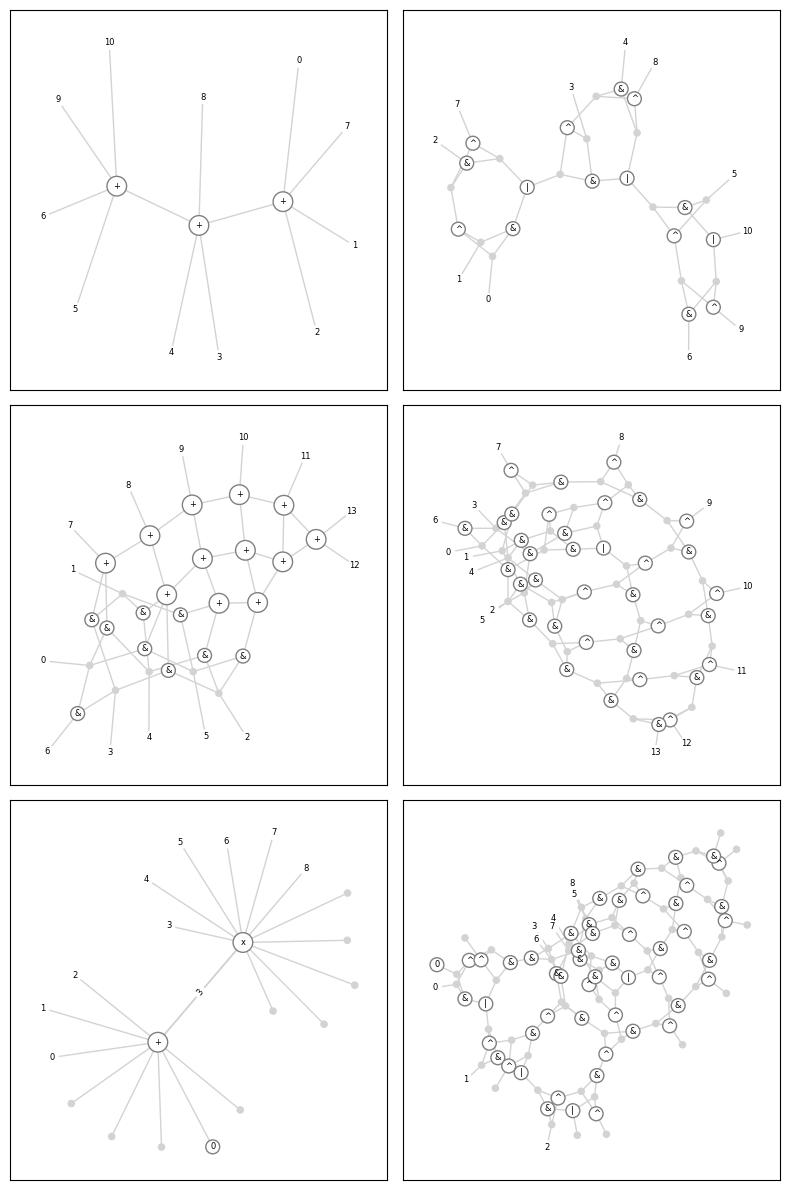

In [30]:
draw_diagram.s(
    madd_3.blocks[2],
    madd_3.blocks[2].flatten(),
    madd_3.blocks[0],
    madd_3.blocks[0].flatten(),
    madd_3,
    madd_3.flatten(),
    node_label={
        "box": binop_labels,
        "subdiagram": {
            wallace_multiplier: "x",
            rc_adder: "+",
            full_adder: "+",
            half_adder: "+",
        }
    },
    subplots=(3, 2),
    figsize=(8, 12),
)


## Contraction

**TODO:** Talk about contraction for diagrams.